In [2]:
import sys
from os.path import join, exists, abspath
from glob import glob

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import colormaps, cm, colors
import matplotlib.patches as patches
from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes, mark_inset
import h5py
import scipy
import seaborn as sns

from tqdm import tqdm

In [2]:
import nibabel as nib
# import nitools as nt
import nilearn
from nilearn.plotting import plot_surf, view_img

In [3]:
print(nilearn.__version__)

0.11.1


In [4]:
# np.set_printoptions(linewidth=20)

---

In [5]:
dir_git = 'D:/mobaxterm/sungbeenpark/github'
dir_work = join(dir_git,'diedrichsenlab/SeqSpatialSupp_fMRI')
exists(dir_work)

True

In [6]:
dir_data = 'D:/milli/diedrichsenlab/SeqSpatialSupp_fMRI'
exists(dir_data)

True

In [8]:
path_module = abspath(join(dir_git,'nitools'))
if exists(path_module):
    print('added the path, %s'%path_module)
    if path_module not in sys.path:
        sys.path.append(path_module)

import nitools as nt

added the path, D:\mobaxterm\sungbeenpark\github\nitools


In [9]:
path_module = abspath(join(dir_git,'SUITPy'))
if exists(path_module):
    print('added the path, %s'%path_module)
    if path_module not in sys.path:
        sys.path.append(path_module)

import SUITPy as suit

added the path, D:\mobaxterm\sungbeenpark\github\SUITPy


In [10]:
path_module = abspath(dir_git)
if exists(path_module):
    print('added the path, %s'%path_module)
    if path_module not in sys.path:
        sys.path.append(path_module)

import surfAnalysisPy as surf

added the path, D:\mobaxterm\sungbeenpark\github


In [11]:
dir_atlas = join(dir_git,'diedrichsenlab/atlas/fs_LR_32k')
hemN = ['L','R']
print(exists(dir_atlas))
print(len(glob(join(dir_atlas,'*'))))

True
85


---

## Contrast

$$RDM = \begin{bmatrix}
\textcolor{gray}{B} & C & C & C & S & N & N & N \\
C & \textcolor{gray}{B} & C & C & N & S & N & N \\
C & C & \textcolor{gray}{B} & C & N & N & S & N \\
C & C & C & \textcolor{gray}{B} & N & N & N & S \\
S & N & N & N & \textcolor{gray}{B} & C & C & C \\
N & S & N & N & C & \textcolor{gray}{B} & C & C \\
N & N & S & N & C & C & \textcolor{gray}{B} & C \\
N & N & N & S & C & C & C & \textcolor{gray}{B}
\end{bmatrix}$$
The number of elements on the upper triangle $= \frac{8\cdot 7}{2} = 28$
1. B: both of cue and sequence repetition (8 trials)
2. S: only sequence repetition (8 trials)
3. C: only cue repetition (24 trials)
4. N: no repetition (24 trials)

- Conditions:
    1. MotorOnly-L (S)
    2. MotorOnly-S (S)
    3. CueOnly-L (C)
    4. CueOnly-S (C)
    5. BothRep-L (B)
    6. BothRep-S (B)
    7. NonRep-L (N)
    8. NonRep-S (N)
    9. Non-Interest

- Contrasts:
    1. BothRep-L:  $c=[0\ 0\ 0\ 0\ 1\ 0\ 0\ 0\ 0]$
    2. CueRep-L:   $c=[0\ 0\ 1\ 0\ 0\ 0\ 0\ 0\ 0]$
    3. MotorRep-L: $c=[1\ 0\ 0\ 0\ 0\ 0\ 0\ 0\ 0]$
    4. NRep-L:     $c=[0\ 0\ 0\ 0\ 0\ 0\ 1\ 0\ 0]$
    5. BothRep-S:  $c=[0\ 0\ 0\ 0\ 0\ 1\ 0\ 0\ 0]$
    6. CueRep-S:   $c=[0\ 0\ 0\ 1\ 0\ 0\ 0\ 0\ 0]$
    7. MotorRep-S: $c=[0\ 1\ 0\ 0\ 0\ 0\ 0\ 0\ 0]$
    8. NRep-S:     $c=[0\ 0\ 0\ 0\ 0\ 0\ 0\ 1\ 0]$
    9. wRS-L:      $c=[0\ 0\ \!-\!1\ 0\ 1\ 0\ 0\ 0\ 0]$
    10. wRS-S:     $c=[0\ 0\ 0\ \!-\!1\ 0\ 1\ 0\ 0\ 0]$
    11. wRS-L-S:   $c=[0\ 0\ \!-\!1\ \!-\!1\ 1\ 1\ 0\ 0\ 0]$
    12. acRS-L:    $c=[1\ 0\ 0\ 0\ 0\ 0\ \!-\!1\ 0\ 0]$
    13. acRS-S:    $c=[0\ 1\ 0\ 0\ 0\ 0\ 0\ \!-\!1\ 0]$
    14. acRS-L-S:  $c=[1\ 1\ 0\ 0\ 0\ 0\ \!-\!1\ \!-\!1\ 0]$
    15. Letter:    $c=[1\ 0\ 1\ 0\ 1\ 0\ 1\ 0\ 0]*0.25$
    16. Spatial:   $c=[0\ 1\ 0\ 1\ 0\ 1\ 0\ 1\ 0]*0.25$
    17. L-S:       $c=[1\ \!-\!1\ 1\ \!-\!1\ 1\ \!-\!1\ 1\ \!-\!1\ 0]$

- Calculation:
    $$ \vec{c}\cdot\vec{\beta}=d $$

In [12]:
dir_glm = join(dir_data,'glm_2')
exists(dir_glm)

True

In [13]:
subj = 'S01'

In [14]:
list_cond = [
    'MotorOnly-L', 'MotorOnly-S', 'CueOnly-L', 'CueOnly-S', 'BothRep-L',
    'BothRep-S', 'NonRep-L', 'NonRep-S', 'Non-Interest'
]
for i, _ in enumerate(list_cond):
    output = join(dir_glm,subj,'sungbeen.beta_mean_%02d.nii'%(i+1))
    if exists(output):
        continue
    data_merged = np.zeros((116, 116, 57, 8))
    list_fname = ['beta_%04d.nii'%(i+1+9*j) for j in range(8)]
    for run, fname in enumerate(list_fname):
        img = nib.load(join(dir_glm,subj,fname))
        data_merged[:,:,:,run] = img.get_fdata()
    data_merged = np.nanmean(data_merged, axis=3)
    img_merged = nib.Nifti1Image(data_merged, affine=img.affine)
    nib.save(img_merged, output)

In [15]:
# subj = 'S01'
# fname = glob(join(dir_stat,'%s.L.glm2.psc.func.gii'%subj))[0]
# fname
# img = nb.load(fname)
# list_cond = nt.get_gifti_column_names(img)
list_contrast = [
    'BothRep-L', 'CueRep-L', 'MotorRep-L', 'NRep-L', 'BothRep-S',
    'CueRep-S', 'MotorRep-S', 'NRep-S', 'wRS-L', 'wRS-S',
    'wRS-L-S', 'acRS-L', 'acRS-S', 'acRS-L-S', 'Letter',
    'Spatial', 'Letter-Spatial'
]
vec_contrast = {
    'BothRep-L':[0,0,0,0,1,0,0,0,0],
    'CueRep-L':[0,0,1,0,0,0,0,0,0],
    'MotorRep-L':[1,0,0,0,0,0,0,0,0],
    'NRep-L':[0,0,0,0,0,0,1,0,0],
    'BothRep-S':[0,0,0,0,0,1,0,0,0],
    'CueRep-S':[0,0,0,1,0,0,0,0,0],
    'MotorRep-S':[0,1,0,0,0,0,0,0,0],
    'NRep-S':[0,0,0,0,0,0,0,1,0],
    'wRS-L':[0,0,-1,0,1,0,0,0,0],
    'wRS-S':[0,0,0,-1,0,1,0,0,0],
    'wRS-L-S':[0,0,-1,-1,1,1,0,0,0],
    'acRS-L':[1,0,0,0,0,0,-1,0,0],
    'acRS-S':[0,1,0,0,0,0,0,-1,0],
    'acRS-L-S':[1,1,0,0,0,0,-1,-1,0],
    'Letter':[1,0,1,0,1,0,1,0,0],
    'Spatial':[0,1,0,1,0,1,0,1,0],
    'Letter-Spatial':[1,-1,1,-1,1,-1,1,-1,0]
}
for cont in list_contrast:
    vec = np.array(vec_contrast[cont])
    ## 양수 성분들의 합으로 나눠줘야 PSC를 제대로 구할 수 있음.
    sum_contrast = vec[vec>1e-10].sum()
    if abs(sum_contrast) > 0:
        vec = vec/sum_contrast
    print(len(vec), vec, sum_contrast)
    vec_contrast[cont] = vec

9 [0. 0. 0. 0. 1. 0. 0. 0. 0.] 1
9 [0. 0. 1. 0. 0. 0. 0. 0. 0.] 1
9 [1. 0. 0. 0. 0. 0. 0. 0. 0.] 1
9 [0. 0. 0. 0. 0. 0. 1. 0. 0.] 1
9 [0. 0. 0. 0. 0. 1. 0. 0. 0.] 1
9 [0. 0. 0. 1. 0. 0. 0. 0. 0.] 1
9 [0. 1. 0. 0. 0. 0. 0. 0. 0.] 1
9 [0. 0. 0. 0. 0. 0. 0. 1. 0.] 1
9 [ 0.  0. -1.  0.  1.  0.  0.  0.  0.] 1
9 [ 0.  0.  0. -1.  0.  1.  0.  0.  0.] 1
9 [ 0.   0.  -0.5 -0.5  0.5  0.5  0.   0.   0. ] 2
9 [ 1.  0.  0.  0.  0.  0. -1.  0.  0.] 1
9 [ 0.  1.  0.  0.  0.  0.  0. -1.  0.] 1
9 [ 0.5  0.5  0.   0.   0.   0.  -0.5 -0.5  0. ] 2
9 [0.25 0.   0.25 0.   0.25 0.   0.25 0.   0.  ] 4
9 [0.   0.25 0.   0.25 0.   0.25 0.   0.25 0.  ] 4
9 [ 0.25 -0.25  0.25 -0.25  0.25 -0.25  0.25 -0.25  0.  ] 4


In [16]:
for i, (cont, vec) in enumerate(vec_contrast.items()):
    output = join(dir_glm,subj,'sungbeen.con_%s.nii'%cont)
    if exists(output):
        continue
    list_idx = np.nonzero(vec)[0]
    for j, idx in enumerate(list_idx):
        fname = join(dir_glm,subj,'sungbeen.beta_mean_%02d.nii'%(idx+1))
        img = nib.load(fname)
        data = img.get_fdata()
        coef = vec[idx]
        if j == 0:
            data_con = data * coef
        else:
            data_con = data_con + data * coef
    img_con = nib.Nifti1Image(data_con, affine=img.affine)
    nib.save(img_con, output)

    tmp = data_con - nib.load(join(dir_glm,subj,'con_%s.nii'%cont)).get_fdata()
    print(cont, '%.4f'%np.nansum(abs(tmp)))

In [17]:
# cont = 'acRS-L-S'
# img = nilearn.image.math_img(
#     img1=join(dir_glm,subj,'sungbeen.con_%s.nii'%cont),
#     img2=join(dir_glm,subj,'con_%s.nii'%cont),
#     formula='img1-img2'
# )
# view_img(img)

### Percent Signal Change

The subtraction paradigm is often used in fMRI to find the difference between two 
conditions. These experiments don’t measure the “absolute” percent signal change of a 
signal from rest, but rather the difference of two signals, or relative percent signal 
change. Contrasts in the GLM are comparisons of one effect size to another. As long as 
each effect was estimated in percent signal change, then the difference between them is in 
percent signal change. However, for multiple session experiments, the same contrast 
could be counted multiple times. Similarly, in combined contrasts, there may be several 
contrasts that are added together. The contrast image is generated as the sum of images as 
described by the contrast vector

In order to find the average contrast, we need to divide by the sum of the positive 
contrasts (there are an equal number of negative contrasts since the sum is zero). Thus, 
the third quantitative scale factor is the sum of positive values in the contrast vector. The 
contrast sum, $contrastsum$, depends on the particular contrast being analyzed, and must be 
calculated separately for each contrast. (A beta image does not need this scaling, as it is 
equivalent to having a contrast vector with a single 1 and all other values being zero, thus 
its $contrastsum = 1$.) 
Thus, the complete scaling for percent signal change of contrasts is that:
 
$$ con(\%) = (con/contrastsum) * (peak/bmean) * 100 $$
where $con$ is contrast image produced by SPM estimation. This formula is most accurate 
for isolated blocks or events, but may underestimate true effect sizes in rapid event 
experiments.

In [18]:
def psc_formula(num_run):
    if num_run < 2:
        raise ValueError("num_run must be 2 or greater.")

    # numerator: 'i<num_run + 1>'
    numerator = f"i{num_run + 1}"

    # variables: ['i1', 'i2', ..., 'i<num_run>']
    variables = [f"i{i}" for i in range(1, num_run + 1)]

    # denominator: '(i1+i2+...+i<num_run>)'
    denominator = f"({'+'.join(variables)})"

    # Final formula: 'numerator / (denominator / num_run)'
    calc_psc_formula = f"{numerator}./({denominator}/{num_run})"

    return calc_psc_formula

In [19]:
psc_formula(8)

'i9./((i1+i2+i3+i4+i5+i6+i7+i8)/8)'

In [20]:
list_fname = sorted(glob(join(dir_glm,'???/SPM.mat')))
list_fname

['D:/milli/diedrichsenlab/SeqSpatialSupp_fMRI\\glm_2\\R01\\SPM.mat',
 'D:/milli/diedrichsenlab/SeqSpatialSupp_fMRI\\glm_2\\R02\\SPM.mat',
 'D:/milli/diedrichsenlab/SeqSpatialSupp_fMRI\\glm_2\\R03\\SPM.mat',
 'D:/milli/diedrichsenlab/SeqSpatialSupp_fMRI\\glm_2\\R05\\SPM.mat',
 'D:/milli/diedrichsenlab/SeqSpatialSupp_fMRI\\glm_2\\R06\\SPM.mat',
 'D:/milli/diedrichsenlab/SeqSpatialSupp_fMRI\\glm_2\\R08\\SPM.mat',
 'D:/milli/diedrichsenlab/SeqSpatialSupp_fMRI\\glm_2\\R09\\SPM.mat',
 'D:/milli/diedrichsenlab/SeqSpatialSupp_fMRI\\glm_2\\R10\\SPM.mat',
 'D:/milli/diedrichsenlab/SeqSpatialSupp_fMRI\\glm_2\\R11\\SPM.mat',
 'D:/milli/diedrichsenlab/SeqSpatialSupp_fMRI\\glm_2\\R12\\SPM.mat',
 'D:/milli/diedrichsenlab/SeqSpatialSupp_fMRI\\glm_2\\R13\\SPM.mat',
 'D:/milli/diedrichsenlab/SeqSpatialSupp_fMRI\\glm_2\\R14\\SPM.mat',
 'D:/milli/diedrichsenlab/SeqSpatialSupp_fMRI\\glm_2\\S01\\SPM.mat',
 'D:/milli/diedrichsenlab/SeqSpatialSupp_fMRI\\glm_2\\S02\\SPM.mat',
 'D:/milli/diedrichsenlab/SeqSpati

In [21]:
fname = join(dir_glm,subj,'SPM.mat')

feature = h5py.File(fname)
print(feature.keys())

data = feature['SPM']
data.keys()

<KeysViewHDF5 ['#refs#', 'SPM']>


<KeysViewHDF5 ['ResStats', 'SPMid', 'Sess', 'VM', 'VResMS', 'Vbeta', 'factor', 'nscan', 'swd', 'xBF', 'xCon', 'xGX', 'xM', 'xVi', 'xVol', 'xX', 'xY', 'xsDes']>

In [22]:
print(data['xCon'].keys())
print(len(list_contrast))
data['xCon']['name']

<KeysViewHDF5 ['STAT', 'Vcon', 'Vspm', 'X0', 'X1o', 'c', 'eidf', 'iX0', 'name']>
17


<HDF5 dataset "name": shape (17, 1), type "|O">

In [23]:
print(data['xX'].keys())
tmp = data['xX']['X']
mat_X_interest = tmp[:72,:]
mat_X_nointerest = tmp[72:,:]
print(mat_X_interest.shape, mat_X_nointerest.shape)

<KeysViewHDF5 ['Bcov', 'K', 'V', 'W', 'X', 'erdf', 'iB', 'iC', 'iG', 'iH', 'nKX', 'name', 'pKX', 'trRV', 'trRVRV', 'xKXs']>
(72, 3280) (8, 3280)


<Axes: >

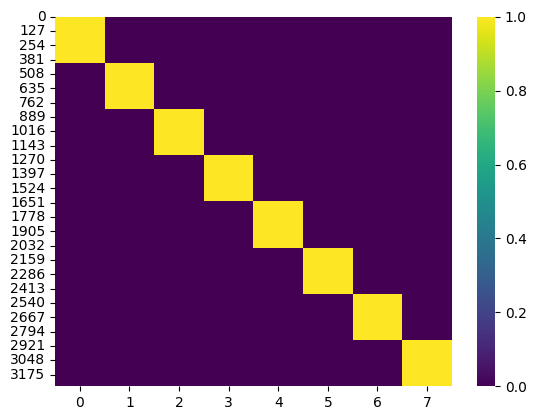

In [24]:
sns.heatmap(np.transpose(mat_X_nointerest), cmap='viridis')

<Axes: >

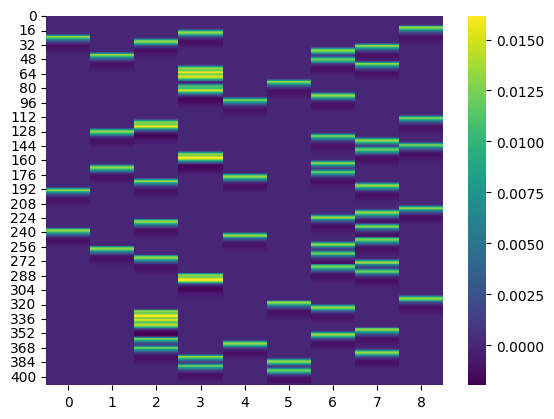

In [25]:
sns.heatmap(np.transpose(mat_X_interest[:9,:410]), cmap='viridis')

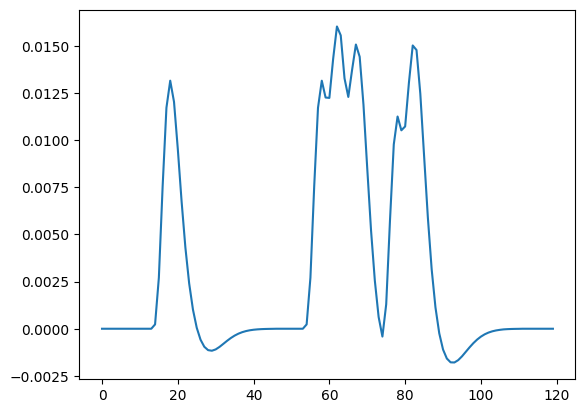

In [26]:
plt.plot(mat_X_interest[3,:120])

np.float64(0.013156380695218945)

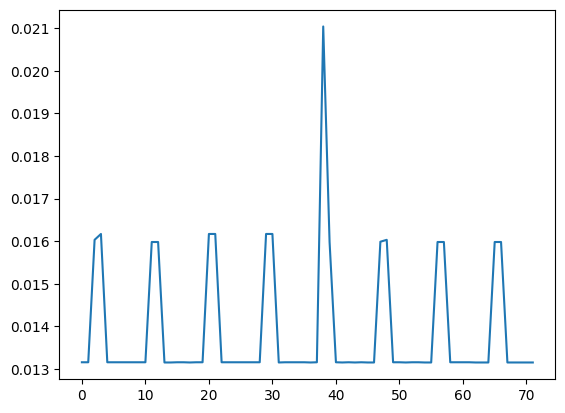

In [27]:
h = np.median(
    np.max(mat_X_interest, axis=1)
)
plt.plot(np.max(mat_X_interest, axis=1))
h

In [28]:
# formula
print('100 * %f * %s'%(h, psc_formula(8)))

100 * 0.013156 * i9./((i1+i2+i3+i4+i5+i6+i7+i8)/8)


BothRep-L (116, 116, 57)
CueRep-L (116, 116, 57)
MotorRep-L (116, 116, 57)
NRep-L (116, 116, 57)
BothRep-S (116, 116, 57)
CueRep-S (116, 116, 57)
MotorRep-S (116, 116, 57)
NRep-S (116, 116, 57)
wRS-L (116, 116, 57)
wRS-S (116, 116, 57)
wRS-L-S (116, 116, 57)
acRS-L (116, 116, 57)
acRS-S (116, 116, 57)
acRS-L-S (116, 116, 57)
Letter (116, 116, 57)
Spatial (116, 116, 57)
Letter-Spatial (116, 116, 57)


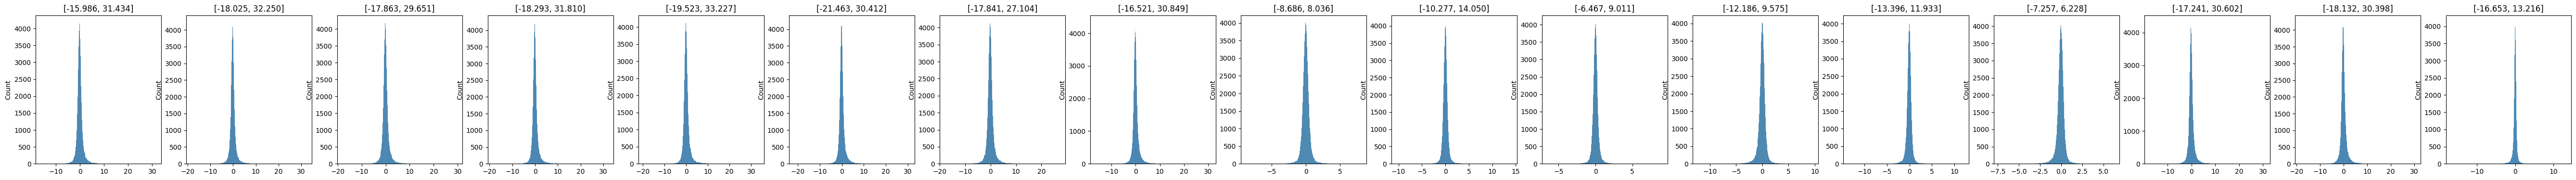

In [29]:
subj = 'S01'
ncols = len(list_contrast)

fig, axs = plt.subplots(ncols=ncols, figsize=(4*ncols,4))

for cc, con in enumerate(list_contrast):
    ax = axs[cc]
    fname = join(dir_glm,'%s/psc_%s.nii'%(subj,con))
    img = nib.load(fname)
    print(con, img.shape)
    fdata = img.get_fdata()
    g = sns.histplot(fdata.reshape(-1), ax=ax)
    g.set_title('[%.3f, %.3f]'%(np.nanmin(fdata),np.nanmax(fdata)))

---

## FreeSurfer

In [19]:
underlay = join(dir_atlas,'fs_LR.32k.LR.sulc.dscalar.gii')

In [21]:
glob(join(dir_atlas,'*.border'))

['D:/mobaxterm/psb629/github/diedrichsenlab/atlas/fs_LR_32k\\fs_LR.32k.L.border-CS.border',
 'D:/mobaxterm/psb629/github/diedrichsenlab/atlas/fs_LR_32k\\fs_LR.32k.L.border-IPS.border',
 'D:/mobaxterm/psb629/github/diedrichsenlab/atlas/fs_LR_32k\\fs_LR.32k.L.border-PoCS.border',
 'D:/mobaxterm/psb629/github/diedrichsenlab/atlas/fs_LR_32k\\fs_LR.32k.L.border-SF.border',
 'D:/mobaxterm/psb629/github/diedrichsenlab/atlas/fs_LR_32k\\fs_LR.32k.R.border-CS.border',
 'D:/mobaxterm/psb629/github/diedrichsenlab/atlas/fs_LR_32k\\fs_LR.32k.R.border-IPS.border',
 'D:/mobaxterm/psb629/github/diedrichsenlab/atlas/fs_LR_32k\\fs_LR.32k.R.border-PoCS.border',
 'D:/mobaxterm/psb629/github/diedrichsenlab/atlas/fs_LR_32k\\fs_LR.32k.R.border-SF.border',
 'D:/mobaxterm/psb629/github/diedrichsenlab/atlas/fs_LR_32k\\Icosahedron-42.32k.L.border',
 'D:/mobaxterm/psb629/github/diedrichsenlab/atlas/fs_LR_32k\\parcellations_VGD11b.L.32k_fs_LR.border',
 'D:/mobaxterm/psb629/github/diedrichsenlab/atlas/fs_LR_32k\\par

In [23]:
flatsurf = [] # Flat surface

for h,hem in enumerate(hemN):
    flatsurf.append(join(dir_atlas,'fs_LR.32k.' + hem + '.flat.surf.gii'))
flatsurf = sorted(flatsurf)
flatsurf

['D:/mobaxterm/psb629/github/diedrichsenlab/atlas/fs_LR_32k\\fs_LR.32k.L.flat.surf.gii',
 'D:/mobaxterm/psb629/github/diedrichsenlab/atlas/fs_LR_32k\\fs_LR.32k.R.flat.surf.gii']

column heads (1):
 ['col_1']


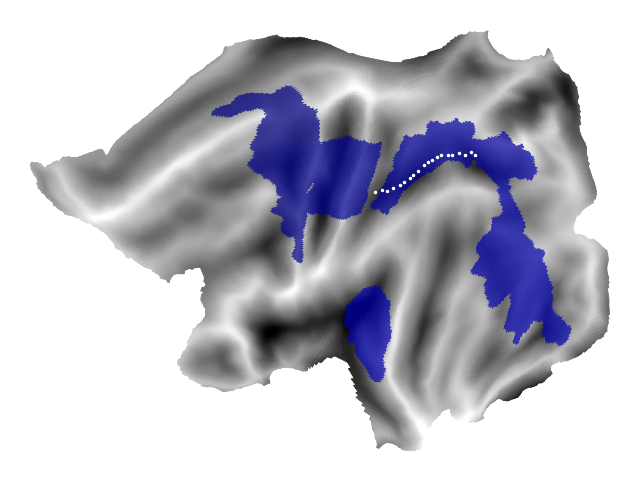

In [25]:
roi = nb.load(join(dir_atlas,'ROI.L.SSS.label.gii'))
fig = plt.figure(figsize=(8,6))
ax = surf.plot.plotmap(
    data=roi,
    surf=flatsurf[0], underlay=underlay, alpha=0.7,
    borders=join(dir_atlas,'fs_LR.32k.L.border-IPS.border'), bordercolor='white', bordersize=3,
    cmap=cm.jet,
    # overlay_type='label', label_names=['SMA','PMv','PMd','M1','S1','aSPL','pSPL','DSVC']
)

cols = nt.get_gifti_column_names(roi)
print('column heads (%d):\n'%len(cols),cols)

---

## Repetition Suppression (GLM2)

In [1]:
dir_stat = join(dir_data,'surfaceWB/glm2.onset0/psc')
exists(dir_stat)

NameError: name 'join' is not defined

### Individual

In [139]:
subj = 'S01'
fname = glob(join(dir_stat,'%s.L.glm2.psc.func.gii'%subj))[0]
img = nb.load(fname)
data = img.darrays[0].data

(0.0, 5.0)

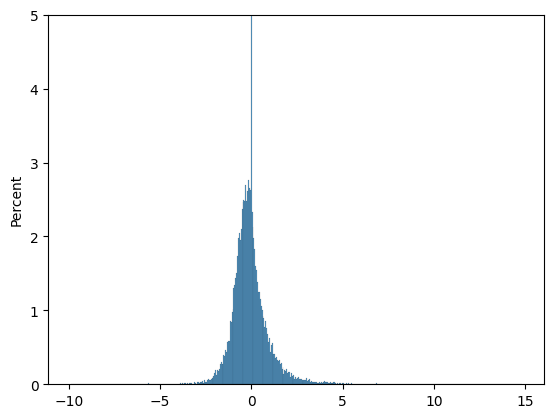

In [141]:
g = sns.histplot(data, stat='percent')
g.set_ylim(0,5)

In [142]:
data[abs(data)<1]=np.nan

<Axes: >

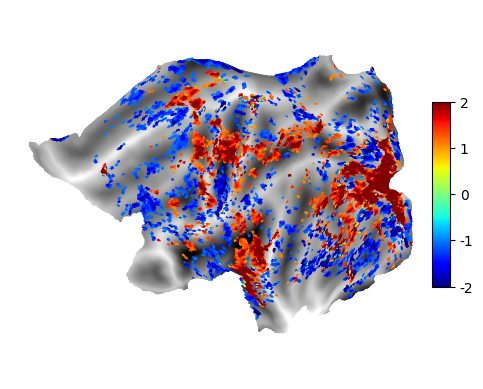

In [143]:
surf.plot.plotmap(
    data=data,
    surf=flatsurf[0], underlay=underlay, alpha=0.7,
    cmap=cm.jet, colorbar=True, cscale=[-2,2]
    # overlay_type='label', label_names=['SMA','PMv','PMd','M1','S1','aSPL','pSPL','DSVC']
)

### Group

In [26]:
list_stat = [
    'BothRep-L', 'BothRep-S', 'CueRep-L', 'CueRep-S', 'Letter',
    'Letter-Spatial', 'MotorRep-L', 'MotorRep-S', 'NRep-L', 'NRep-S',
    'Spatial', 'acRS-L', 'acRS-L-S', 'acRS-S', 'wRS-L', 'wRS-L-S','wRS-S'
]
list_stat

['BothRep-L',
 'BothRep-S',
 'CueRep-L',
 'CueRep-S',
 'Letter',
 'Letter-Spatial',
 'MotorRep-L',
 'MotorRep-S',
 'NRep-L',
 'NRep-S',
 'Spatial',
 'acRS-L',
 'acRS-L-S',
 'acRS-S',
 'wRS-L',
 'wRS-L-S',
 'wRS-S']

['R01', 'R02', 'R03', 'R05', 'R06', 'R08', 'R09', 'R10', 'R11', 'R12', 'R13', 'R14']
wRS-S


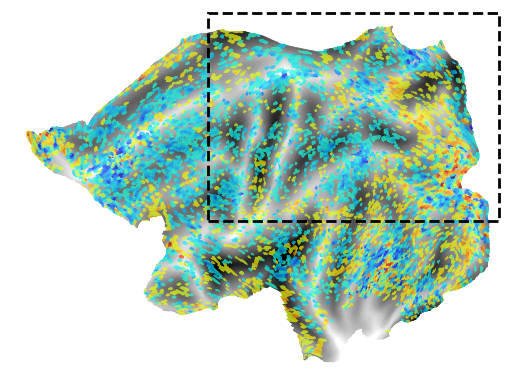

In [81]:
fig, ax = plt.subplots()

stat = 'wRS-S'
group = 'R_all'
fname = join(dir_stat,'group32k/group.%s.psc.L.glm2.%s.func.gii'%(group,stat))
# fname = join(dir_stat,'group32k_opt/group.psc.L.glm2.%s.func.gii'%stat)
# fname = join(dir_stat,'group32k_dur1/group.psc.L.glm2.%s.func.gii'%stat)
img = nb.load(fname)
cols = nt.get_gifti_column_names(img)
print(cols)

cmap = cm.jet

for idx, feature in enumerate(cols):
    data = img.darrays[idx].data
    if idx == 0:
        data_group = data
    else:
        data_group += data
data_group /= len(cols)

## thresholding
data_group[abs(data_group)<0.1] = np.nan

g = surf.plot.plotmap(
    data=data_group,
    surf=flatsurf[0], underlay=underlay, alpha=0.7,
    cmap=cmap, colorbar=False, cscale=[-0.5,0.5]
    # overlay_type='label', label_names=['SMA','PMv','PMd','M1','S1','aSPL','pSPL','DSVC']
)
print(stat)
# g.text(
#     50,220,
#     stat,
#     fontsize=16,
#     horizontalalignment='center', verticalalignment='center'
# )

# 사각형으로 점선 그리기
rect = patches.Rectangle((-40, 0), 280, 200, linewidth=2, edgecolor='k', facecolor='none', linestyle='--')
ax.add_patch(rect)

In [82]:
fig.savefig(
    join(dir_work,'results/fig.glm2.psc.RS_effect.%s.%s.whole.png'%(group,stat)),
    dpi=300, facecolor=[1,1,1,1],
    bbox_inches = "tight"
)

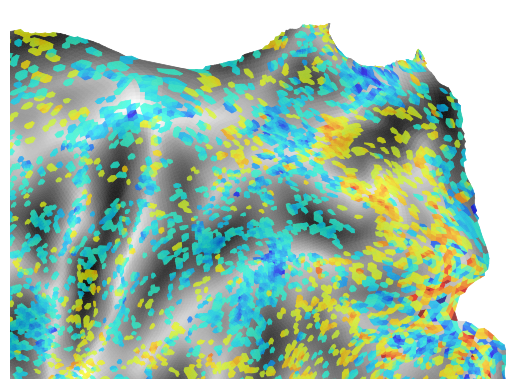

In [83]:
g.set_xlim(50,150)
g.set_ylim(1,195)

fig

In [84]:
fig.savefig(
    join(dir_work,'results/fig.glm2.psc.RS_effect.%s.%s.zoom.png'%(group,stat)),
    dpi=300, facecolor=[1,1,1,1],
    bbox_inches = "tight"
)

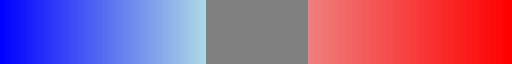

In [160]:
# 색상과 위치 정의 (그라디언트 적용)
color = [
    (0, 'blue'),        # 0에서 파란색 시작
    (0.4, 'lightblue'), # 0.3까지 점진적으로 밝은 파란색으로 변화
    (0.4, 'gray'),      # 0.3에서 회색 시작
    (0.6, 'gray'),      # 0.7까지 회색 유지
    (0.6, 'lightcoral'),# 0.7에서 밝은 빨간색 시작
    (1, 'red')          # 1에서 진한 빨간색으로 변화
]

# 사용자 정의 colormap 생성
cmap = colors.LinearSegmentedColormap.from_list('custom_cmap', color)
cmap

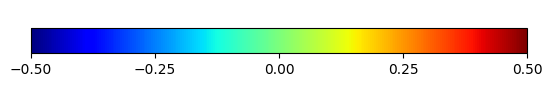

In [168]:
fig, ax = plt.subplots(1, 1)

fraction = 1  # .05

vmin, vmax = -0.5, 0.5
cmap=cm.jet

norm = colors.Normalize(vmin=vmin, vmax=vmax)
cbar = ax.figure.colorbar(
    cm.ScalarMappable(norm=norm, cmap=cmap),
    ax=ax, pad=.05, extend='neither', fraction=fraction,orientation='horizontal',
    ticks=[-0.5,-0.25,0,0.25,0.5]
)

ax.axis('off')
# plt.rcParams["figure.dpi"] = 300

plt.show()

fig.savefig(
    join(dir_work,'results/fig.colorbar.jet.[%.1f,%.1f].png'%(vmin,vmax)),
    dpi=300, facecolor=[1,1,1,1],
    bbox_inches = "tight"
)

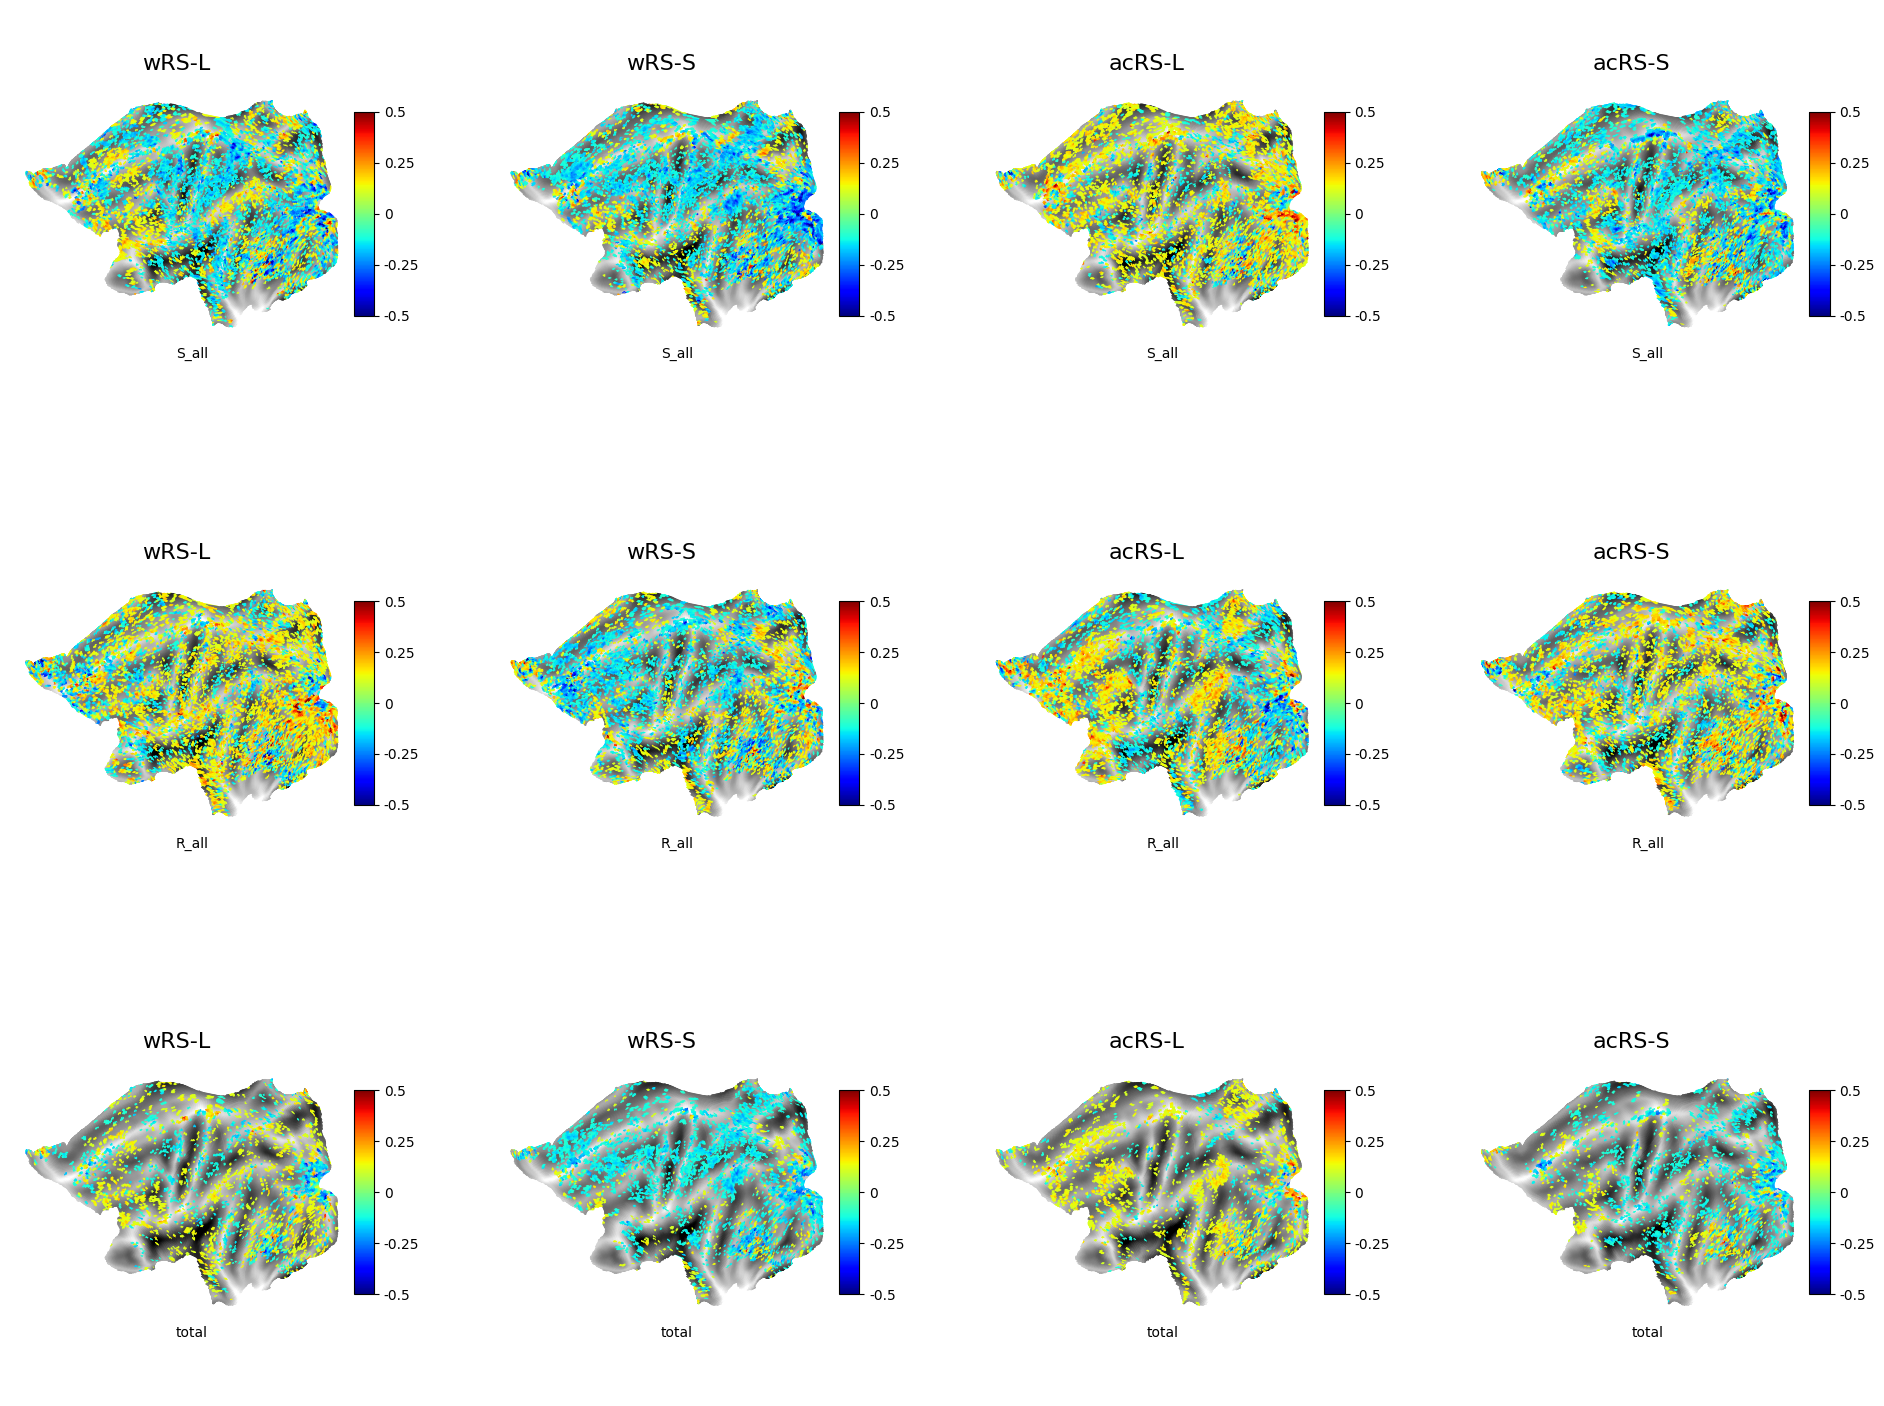

In [171]:
nrows, ncols = 3, 4
fig, axs = plt.subplots(nrows=nrows, ncols=ncols, figsize=(6*ncols,6*nrows))

for ss, stat in enumerate(['wRS-L','wRS-S','acRS-L','acRS-S']):
    for gg, group in enumerate(['S_all', 'R_all', 'total']):
        ax = axs[gg,ss]
        ## load data
        if not group=='total':
            # fname = join(dir_stat,'group32k_dur1/group.psc.L.glm2.%s.func.gii'%stat)
            fname = join(dir_stat,'group32k/group.%s.psc.L.glm2.%s.func.gii'%(group,stat))
        else:
            fname = join(dir_stat_opt,'group.psc.L.glm2.%s.func.gii'%stat)
        # exists(fname)
        img = nb.load(fname)
        cols = nt.get_gifti_column_names(img)
        # print('column heads (%d):\n'%len(cols),cols)
        
        # feature = 'R08'
        # idx = nt.get_gifti_column_names(img).index(feature)
        
        for idx, feature in enumerate(cols):
            data = img.darrays[idx].data
            # array = data.copy()
            # mean = np.mean(array)
            # std = np.std(array)
            # data_normalized = (array - mean) / std
            if idx == 0:
                # data_group = data_normalized
                data_group = data
            else:
                # data_group += data_normalized
                data_group += data
        data_group /= len(cols)

        ## thresholding
        data_group[abs(data_group)<0.1] = np.nan
        
        plt.sca(ax)
        g = surf.plot.plotmap(
            data=data_group,
            surf=flatsurf[0], underlay=underlay,
            cmap=cm.jet, colorbar=True, cscale=[-0.5,0.5]
            # overlay_type='label', label_names=['SMA','PMv','PMd','M1','S1','aSPL','pSPL','DSVC']
        )
        g.text(0,-180, group, fontsize=10)
        g.text(
            50,220,
            stat,
            fontsize=16,
            horizontalalignment='center', verticalalignment='center'
        )

In [90]:
fig.savefig(
    join(dir_work,'results/fig.glm2.psc.RS_effect.png'),
    dpi=300, facecolor=[1,1,1,1],
    bbox_inches = "tight"
)

---

### T-test

In [102]:
def visualize_surface(data, contrast_name, pval, LR):
    # data : GiftiImage, e.g., nb.load(base_dir + '/surfaceWB/group32k/summary.L.glm2.psc.sm3.func.gii')
    # contrast_name : str, e.g., 'BothRep-L'
    # LR : left=0 or right=1
    m_idx = nt.get_gifti_column_names(data).index('mean_'+ contrast_name)
    t_idx = nt.get_gifti_column_names(data).index('t_'+ contrast_name)

    # if pval == 0.05:
    #     # calculate t-value for p=0.05 with DoF = 11 with two-tailed test
    #     thresh = 2.201
    # elif pval == 0.01:
    #     thresh = 3.106
    # elif pval == 0.005:
    #     thresh = 3.496
    # elif pval == 0.001:
    #     thresh = 4.437
    thresh = scipy.stats.t.isf(0.5*pval, df=11)
    
    # get the data
    data_surf = data.darrays[m_idx].data * (abs(data.darrays[t_idx].data) > thresh)
    surf.plot.plotmap(
        data=data_surf,
        surf=flatsurf[LR], underlay=underlay,
        alpha=1,
        cscale=[-3, 3], threshold=[-0.0001, 0.0001], colorbar=True,
    )

In [104]:
fname = join(dir_stat,'group32k_opt/summary.L.glm2.psc.sm3.func.gii')
exists(fname)

True

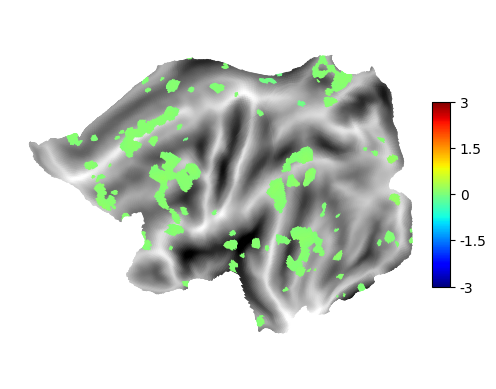

In [108]:
stat = 'acRS-L'
img = nb.load(fname)
visualize_surface(img,stat,0.05,0)

In [75]:
idx = nt.get_gifti_column_names(img).index('mean_%s'%stat)
data = img.darrays[idx].data
data.shape

(32492,)

<Axes: >

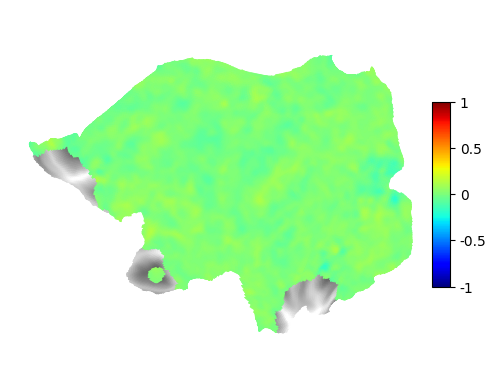

In [82]:
surf.plot.plotmap(
    data=data,
    surf=flatsurf[0], underlay=underlay,
    cmap=cm.jet, colorbar=True, cscale=[vmin,vmax],
    # overlay_type='label', label_names=['SMA','PMv','PMd','M1','S1','aSPL','pSPL','DSVC']
)

In [88]:
nsubjects = 12
nvoxels = 32492 ## 32k
data = np.zeros((nsubjects, nvoxels))
pval = 0.05

In [90]:
stat = 'wRS-L'

# group = 'S_all'
# fname = join(dir_stat,'group32k/group.%s.psc.L.glm2.%s.func.gii'%(group,stat))

fname = join(dir_stat,'group32k_opt/group.psc.L.glm2.%s.func.gii'%stat)

img = nb.load(fname)

cols = nt.get_gifti_column_names(img)
for idx, feature in enumerate(cols):
    array = img.darrays[idx].data
    # mean = np.mean(array)
    # std = np.std(array)
    # data[idx,:] = (array - mean) / std
    data[idx,:] = array.copy()
res = scipy.stats.ttest_1samp(data, axis=0, popmean=0, alternative='two-sided')
thresh = scipy.stats.t.isf(0.5*pval, df=res.df[0])
print('upper tail probability:',thresh)

data_mean = data.mean(axis=0)

upper tail probability: 2.200985160082949


In [64]:
tval = res.statistic.copy()
print(tval.shape)
# data_mean *= (abs(tval) > thresh)
data_mean[abs(tval)<thresh] = np.nan
# tmp = abs(tmp[abs(tmp)>0.01])
# vmax = max(tmp.min(), tmp.max())
# vmin = -vmax
vmin, vmax = -1, 1
# cutline = tmp.min()
# print(vmin, vmax, cutline)
# min(data.mean(axis=0))

(32492,)


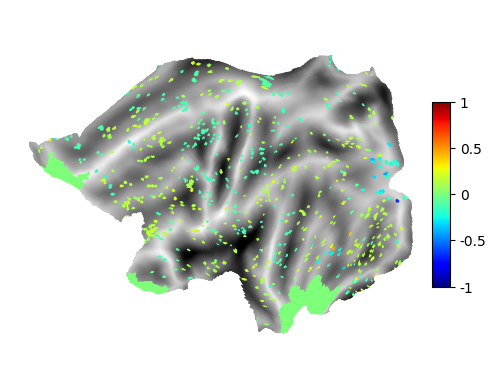

In [431]:
g = surf.plot.plotmap(
    data=data_mean,
    surf=flatsurf[0], underlay=underlay,
    cmap=cm.jet, colorbar=True, cscale=[vmin,vmax],
    # overlay_type='label', label_names=['SMA','PMv','PMd','M1','S1','aSPL','pSPL','DSVC']
)

In [90]:
fig.savefig(
    join(dir_work,'results/fig.glm2.psc.RS_effect.png'),
    dpi=300, facecolor=[1,1,1,1],
    bbox_inches = "tight"
)

---

## Smoothing

### Normal distribution

If the considered function is the density of a **normal distribution** of the form:
$$
f(x)=\frac{1}{\sigma\sqrt{2\pi}}\exp{\Big[-\frac{(x-x_{0})^{2}}{2\sigma^{2}}\Big]}
$$
where $\sigma$ is the **standard deviation** and $x_{0}$ is the **expected value**, then the relationship between *full width at half maximum* (FWHM) and the standard deviation is:
$$
\text{FWHM}=2\sqrt{2\ln{2}}\sigma\approx2.355\sigma
$$

In [35]:
subj = 'S01'
fname = glob(join(dir_stat,'%s.L.glm2.psc.func.gii'%subj))[0]
fname
img = nb.load(fname)
cols = nt.get_gifti_column_names(img)
cols

['BothRep-L',
 'CueRep-L',
 'MotorRep-L',
 'NRep-L',
 'BothRep-S',
 'CueRep-S',
 'MotorRep-S',
 'NRep-S',
 'wRS-L',
 'wRS-S',
 'wRS-L-S',
 'acRS-L',
 'acRS-S',
 'acRS-L-S',
 'Letter',
 'Spatial',
 'Letter-Spatial']

In [37]:
img.darrays[0].data

array([ 0.00931335, -0.3850282 ,  0.74722946, ...,  0.13999757,
       -0.2937485 , -0.53004295], dtype=float32)

In [ ]:
scipy.ndimage.gaussian_filter(
    input=img.darrays[0].data,
    
)

D:/diedrichsenlab/SeqSpatialSupp_fMRI/surfaceWB/glm2/psc\group32k_dur1/summary.L.glm2.psc.sm3.func.gii


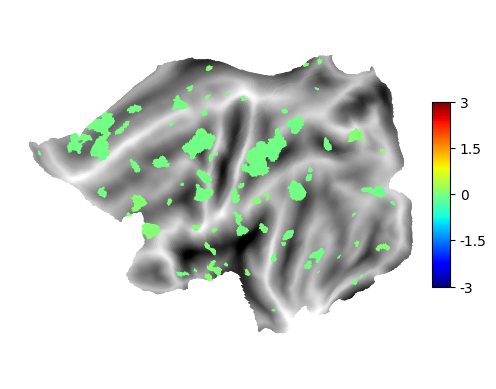

In [44]:
print(fname)
visualize_surface(img, 'wRS-L-S', pval=0.05, LR=0)

---